#Tree based models with processed cgm peak data set and macronutrients.

#use cgm (Python 3.11.11) kernel

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import shap

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, ShuffleSplit

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import (DecisionTreeClassifier as DTC ,
DecisionTreeRegressor as DTR ,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,
log_loss)
from sklearn.ensemble import \
(RandomForestRegressor as RFR,
RandomForestClassifier as RFC,
GradientBoostingRegressor as GBR,
GradientBoostingClassifier as GBC)

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'generated_data')
file_path = os.path.join(data_dir, 'df_output.csv')

df = pd.read_csv(file_path)

### Define subsets columns
factors=['exercise_within_3h','meal_time_category','Protein','Fat','Carbs','Calories']

### Define features and target
y_var='glucose_auc'
#y_var=glucose_max
#y_var=glucose_rate_rise
#y_var=glucose_rate_fall
x_var=factors
X=df[x_var]
y=np.array(df[y_var]).reshape(-1,1)
print(X.shape)
print(y.shape)

(37, 6)
(37, 1)


A random forest is trained to predict values of y. A learning curve is plotted with RMSE vs number of trees. 

With sklearn there are differences in getting the training curve, cross validation curve (oob error), and the test curve. 

Typically # of trees doesn't overfit (test error doesn't go up). Averageing overfit models still creates a smooth, stable ensemble. Also reduced variance.

In OOB estimation, roughly 2/3 is used in a bagged tree. 1/3 observations are not used to fit a bagged tree, used as OOB. So we we naturally have validation. Better computationally!!
"The resulting OOB error is a valid estimate of the test error for the bagged model, since the response for each
observation is predicted using only the trees that were not fit using that observation."



c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably m

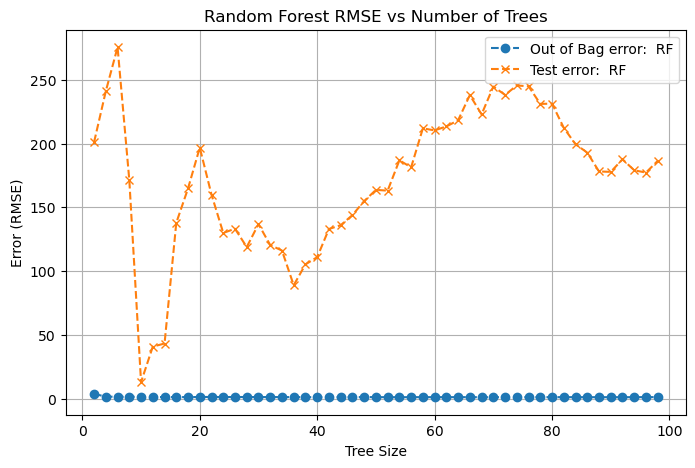

In [7]:

(X_train ,X_test,y_train ,y_test) = train_test_split(X,y,test_size=0.3,random_state=5)

num_trees = list(range(2,100,2))
error_oob_rf=[]
error_test_rf=[]

for i in num_trees:
    rfg=RFR(n_estimators=i,random_state=0,max_features='sqrt',oob_score=True, )
    rfg.fit(X_train,y_train)
    oob_error=1-rfg.oob_score_
    error_oob_rf.append(oob_error)
    test_error=np.sqrt((np.mean(y_test-rfg.predict(X_test)))**2)
    error_test_rf.append(test_error)

plt.figure(figsize=(8, 5))
plt.plot(num_trees, error_oob_rf, marker='o', linestyle='--', label="Out of Bag error:  RF")
plt.plot(num_trees, error_test_rf, marker='x', linestyle='--', label="Test error:  RF")
plt.xlabel("Tree Size")
plt.ylabel("Error (RMSE)")
plt.title("Random Forest RMSE vs Number of Trees")
plt.legend()
plt.grid()
plt.show()


How its useful for variable importance:
Its an overall summary of importance each predictor, using RSS (for regression trees)
Or Gini Index (for classification trees)

c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


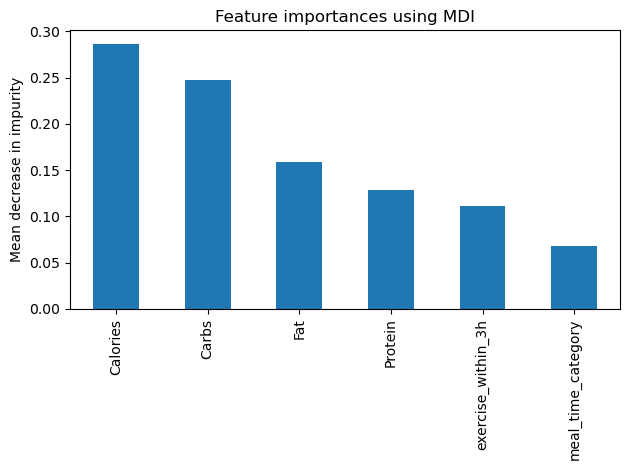

In [11]:
rfg=RFR(n_estimators=10,random_state=0,max_features='sqrt',oob_score=True, )
rfg.fit(X_train,y_train)

feature_names=X.columns
importances = rfg.feature_importances_

feature_importance=pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


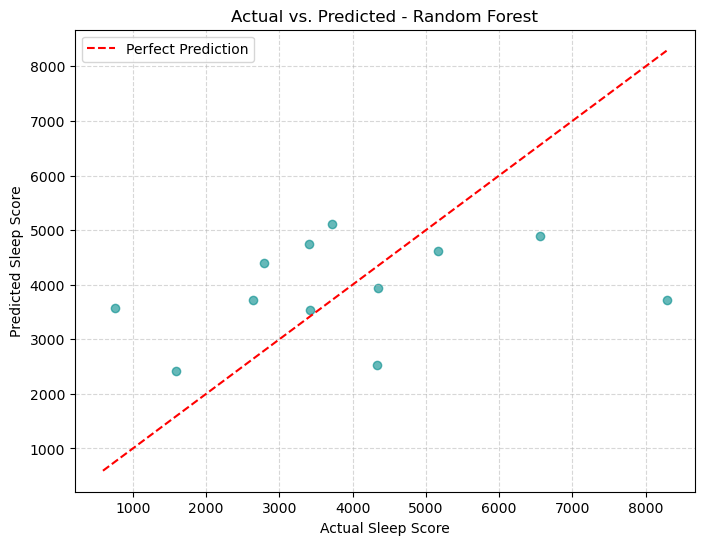

R²: 0.072
RMSE: 1901.888
MAE: 1514.241


c:\Users\jhuang\AppData\Local\anaconda3\envs\health\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
y_pred = rfg.predict(X_test)

# Actual vs. Predicted Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="darkcyan")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Sleep Score")
plt.ylabel("Predicted Sleep Score")
plt.title("Actual vs. Predicted - Random Forest")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Performance metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

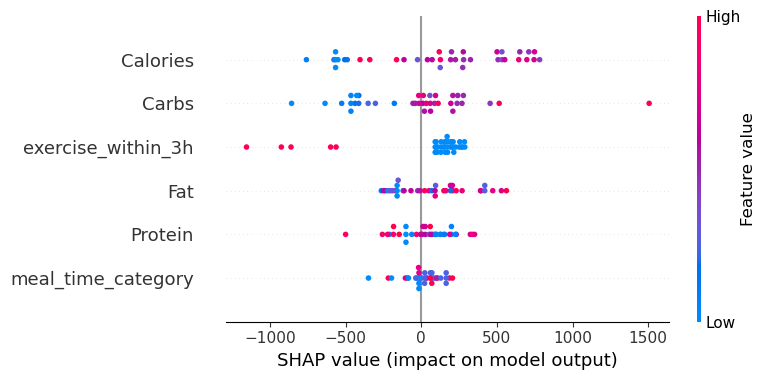

In [13]:
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(X)  # SHAP values for each row (same shape as X)
shap.summary_plot(shap_values, X)

Lecture - Boosting
Start with Adaboost

RF:
1. Trees
2. equal says
3. trees are independent.

Adaboost:
1. Stumps
2. some stumps worth more
3. stump takes into accout previous stumps.

Determine first stump. Is the variable that has the lowest gini index.
Then determine how much say it will have in the final classification.
Based on Total error rate of split, find amount of say. Then use amount of say to weight sample.
Can use weighted gini function and use it with sample weights. ortherwise just sample weights as a probability and make a new dataset that reflects those weights.

For classification. total amount of say for all the stumps for 1 class, that determines class. 

Gradient Boost.
Usually predetermined. Max leaves = 4 in this case. Predict the residuals.

In regression settings:
Start with average value.
Loop: 
    Calculate residuals.
    Predict these residuals with a tree. For leaves with multiple values, replace with average.
    Now we predict values = avg value + alpha*(tree). Learning rate acts as the 'gradient.' Small steps in right direction. lower variance.
Go until residuals stop or hit max number of trees


1. Start with leaf.
2. Build tree, based on previous 

| Syntax      | Description |
| ----------- | ----------- |
| Header      | Title       |
| Paragraph   | Text        |


In [14]:
X=df[x_var]
y=np.array(df[y_var]).reshape(-1,1)

(X_train ,X_test,y_train ,y_test) = train_test_split(X,y,test_size=0.3,random_state=15)

gbm = GBC(n_estimators=50, learning_rate=0.1, random_state=42)
gbm.fit(X_train, y_train)
importances = gbm.feature_importances_

feature_importance=pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using XGBoost - MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.